<img src='media/capy.gif' align='center' width="200px">

# Анализ еды в Перекрёстке

**Тема**: анализ продуктов питания [Перекрестка](https://www.perekrestok.ru)

**Основная цель**: выяснить есть ли зависимость между описанием, составом тавара и ценой

**Команда**: Перек ✩

In [2]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import parcer

## Cбор данных

Начнем сбор данных со [страницы каталога](https://www.perekrestok.ru/cat), постепенно углубляясь

Все функции парсинга находятся в `parcer.py`

**Шаг 1** \
Собираем все категории товаров, и ссылки на них

In [3]:
cats = parcer.parce_cats("https://www.perekrestok.ru/cat") # /ᐠ｡ꞈ｡ᐟ\
cats[0]

['Все на дачу', '/cat/mc/1181/vse-na-dacu']

Уберем категории, которые не относятся к продуктам питания

In [8]:
undesired_cats = [
    'Все на дачу',
    'Зоотовары',
    'Для дома и дачи',
    'Красота, гигиена, аптека',
    'Уборка',
    'Товары для мам и детей',
    'Системы нагревания, табак',
    'Посуда',
]

cats = [cat for cat in cats if cat[0] not in undesired_cats]

**Шаг 2** \
По ссылкам на категории, собираем подкатегории и ссылки на подкатегории

In [10]:
subcats = parcer.parce_subcats(cats)
subcats[0]

('Зелёная Линия', 'От Перекрёстка', '/cat/c/284/zelenaa-linia')

Уберем подкатегории, которые не относятся к продуктам питания

In [11]:
undesired_subcats = [
    'Home Story',
    'Kokoro',
    'Honey Kid',
]

subcats = [subcat for subcat in subcats if subcat[0] not in undesired_subcats]

**Шаг 3** \
Теперь благодаря ссылкам на подкатегории мы можем собрать все листинги. В листингах есть ссылки на товары, а также поверхностная информация

In [34]:
listing_products = parcer.parce_listing_products(subcats)
listing_products[0]

['Томаты черри на ветке, 250г',
 '/cat/150/p/tomaty-cerri-na-vetke-250g-3673307',
 'От Перекрёстка',
 'Маркет',
 '4.92',
 '250 гр',
 '179,99 ₽/шт',
 '179,99 ₽',
 '219,99 ₽',
 '-18%',
 '/cat/c/287/market']

In [72]:
parcer.save_listing_products_to_csv('data/listing_products.csv', listing_products)

Список успешно сохранен в файл data/listing_products.csv


**Шаг 4** \
Проходимся по ссылкам из листингов и получаем полную информацию о каждом товаре

In [75]:
products = parcer.parce_products(listing_products)
products[0]

['/cat/150/p/tomaty-cerri-na-vetke-250g-3673307',
 'Томаты черри на ветке, 250г',
 17999,
 '-18%',
 492,
 '15.0',
 '0.8 г',
 '0.1 г',
 '2.8 г',
 'Томаты.',
 'ТД Самарканд Агро',
 'Маркет',
 'Россия',
 '30 дней',
 '15 ℃',
 '5 ℃']

In [67]:
parcer.save_products_to_csv('data/products.csv', products)

Список успешно сохранен в файл data/products.csv


**Итог** \
В файлах *listing_products.csv* и *products.csv* мы собрали информацию о всех товарах в нужных категориях

*listing_products.csv* \
`name` - Название товара \
`href` - Ссылка на товар \
`rating` - Рейтинг товара от 0.00 до 5.00 \
`size` - Вес товара в гр \
`price` - Расценка товара (x/гр или x/кг) \
`new_price` - Цена товара \
`old_price` - Цена без скидки \
`discount` - Скидка или специальное предложение \
`subcat_href` - Ссылка на подкатегорию \
`cat` - Категория товара \
`subcat` - Подкатегория товара 


*products.csv* \
`title` - Название товара \
`product_href` - Ссылка на товар \
`price` - Цена товара \
`discount` - Скидка или специальное предложение \
`rating` - Рейтинг товара от 0.00 до 5.00 \
`kalories` - Калории на 100г \
`proteins` - Белки на 100г \
`fats` - Жиры на 100г \
`carbohydrates` - Углеводы на 100г \
`composition` - Состав продукта \
`manufacturer` - Производитель \
`brand` - Бренд \
`country` - Страна \
`shelf_life` - Срок хранения в днях \
`max_storage_temperature` - Температура хранения макс. \
`min_storage_temperature` - Температура хранения мин.


## Предварительныя обработка

**Шаг 1** \
Соединим собранные данные, удалим лишние столбцы

In [765]:
listing_products_df = pd.read_csv("data/listing_products.csv")
products_df = pd.read_csv("data/products.csv")

df = pd.merge(products_df, listing_products_df, left_on='product_href', right_on='href' , how='left')
df = df.drop(['price_x', 'discount_x', 'title', 'product_href', 'subcat_href','rating_x'], axis=1) 

Переименуем столбцы после слияния и отсортируем

In [766]:
new_names = {
    'rating_y': 'rating',        
    'price_y': 'pricing',
    'discount_y': 'discount',
    'new_price': 'price',
    'cat': 'category',
    'subcat': "subcategory",
}

df = df.rename(columns=new_names)

new_order = [
    'name', 'category', 'subcategory', 'href',
    'kalories', 'proteins', 'fats', 'carbohydrates', 'composition',
    'manufacturer', 'brand', 'country',
    'rating', 'size', 'pricing', 'price', 'old_price', 'discount',
    'shelf_life', 'max_storage_temperature', 'min_storage_temperature',
]

df = df.reindex(columns=new_order)

В некоторых категориях товары дублировались, исправим

In [767]:
df.drop_duplicates(inplace=True, subset=['href', 'name'])
df.dropna(subset=['href'], inplace=True)
df = df.drop(['href'], axis=1) # Удаляем больше не нужную колонку
df = df.reset_index(drop=True)
df.head()

,name,category,subcategory,kalories,proteins,fats,carbohydrates,composition,manufacturer,brand,country,rating,size,pricing,price,old_price,discount,shelf_life,max_storage_temperature,min_storage_temperature
0,Вино Мысхако Quintessence Zinfandel красное по...,Алкогольные напитки,Вино,95.0,0.0 г,0.0 г,0.6 г,"Виноград сорта Зинфандель, пищевая добавка (ко...",Мысхако,Мысхако,Россия,4.89,750 мл,"899,99 ₽/шт","899,99 ₽","899,99 ₽",3 по цене 2-х,9999 дней,20 ℃,5 ℃
1,"Вино Takar Арени красное сухое 14%, 750мл",Алкогольные напитки,Вино,74.0,0.0 г,0.0 г,0.3 г,Виноград сорта Арени; пищевая добавка (консерв...,Armenia Wine,Takar,Армения,4.90,750 мл,"699,99 ₽/шт","699,99 ₽","899,99 ₽",-22%,9999 дней,NaN,5 ℃
2,"Вино Terras de Pegoes красное сухое 12.5%, 750мл",Алкогольные напитки,Вино,75.0,0.0 г,0.0 г,0.1 г,"Сортовой состав винограда: Каштелао - 60%, Али...",Cooperativa Agrícola de Santo Isidro De Pegões,Pegoes,Португалия,4.78,750 мл,"499,99 ₽/шт","499,99 ₽","699,99 ₽",-28%,9999 дней,NaN,NaN
3,"Вино Highway to Hell красное сухое 13%, 750мл",Алкогольные напитки,Вино,79.0,0.0 г,0.0 г,0.0 г,"Виноград сорта Монастрель, пищевая добавка (ко...",Wines N'Roses,Highway to Hell,Испания,4.81,750 мл,"1 099,00 ₽/шт","1 099,00 ₽",NaN,Нет скидки,9999 дней,NaN,5 ℃
4,"Вино Don Garcia красное сухое 11%, 1л",Алкогольные напитки,Вино,0.0,0.0 г,0.0 г,0.0 г,"Красные сорта винограда, пищевая добавка (конс...",J. Garcia Carrion,Don Garcia,Испания,4.75,1000 мл,"549,99 ₽/шт","549,99 ₽",NaN,Нет скидки,9999 дней,20 ℃,5 ℃


**Шаг 2** \
Проверим есть ли пропуски в датасете

In [768]:
df.isnull().sum()

name                          0
category                      0
subcategory                   0
kalories                    267
proteins                    308
fats                        308
carbohydrates               313
composition                 332
manufacturer                398
brand                       532
country                     238
rating                        0
size                        692
pricing                       0
price                         0
old_price                  8989
discount                      0
shelf_life                    0
max_storage_temperature    3777
min_storage_temperature    4627
dtype: int64

Уберем товары не относящиеся к продуктам питания, которые попали в датасет из-за смешанных категорий. \
Для этого найдем все товары с пустыми `kalories` и исключим из них продукты питания

In [769]:
non_food_ids = (df['kalories'].isnull()) & (~df['subcategory'].isin(
                    ["Кофе", "Чай", "Специи, приправы и пряности", 
                    "Соль", "Вся рыба", "Охлаждённая рыба", 
                    "Копчёная рыба", "Вяленая рыба", "Вода", 
                    "Пиво", "Конфеты", "Компоненты для выпечки", 
                    "Молочные коктейли", "Полуфабрикаты", 
                    "Овощи", "Фрукты", "Зелень и салаты", "Коньяк"]))

non_food = df[non_food_ids][["name", 'subcategory']]
df = df[~non_food_ids]

non_food.iloc[5]

name           Губка Волна для обуви и изделий из кожи бесцве...
subcategory                                               Маркет
Name: 6154, dtype: object

Все остальные пропуски `kalories` заполняем нулями

In [770]:
df.loc[df['kalories'].isnull(), 'kalories'] = 0

**Шаг 3** \
Преобразовываем в тип float и заполняем нулями все пропуски `proteins`, `fats` и `carbohydrates`

In [771]:
df.loc[:, 'proteins'] = df['proteins'].str.replace(' г', '').astype(float)
df.loc[:, 'fats'] = df['fats'].str.replace(' г', '').astype(float)
df.loc[:, 'carbohydrates'] = df['carbohydrates'].str.replace(' г', '').astype(float)

df.loc[df['proteins'].isnull(), 'proteins'] = 0
df.loc[df['fats'].isnull(), 'fats'] = 0
df.loc[df['carbohydrates'].isnull(), 'carbohydrates'] = 0

**Шаг 4** \
Так как у нас нет информации о средней плотности всех напитков, в колонке `size` неявно приравняем **мл** к **гр**, переводим во float

In [772]:
df.loc[:, 'size'] = df['size'].str.replace(' гр', '').str.replace(' мл', '').str.replace(' ', '').astype(float)

Расценка `pricing` у товаров на развес 🥒 указывается не за **шт**, а за **кг**, поэтому `size` в этих строках пустой. \
Заполным эти пропуский 1000 гр, а также создадим **новый признак** `is_by_weight`, в котором укажем на развес ли продукт
<a id='is_by_weight'></a>

In [773]:
pricing_units = df['pricing'].str.split('/').str[1]
pricing_units.unique()

array(['шт', 'кг'], dtype=object)

In [774]:
df.loc[pricing_units == 'кг', 'size'] = 1000
df['is_by_weight'] = 1*(pricing_units == 'кг')

Далее `pricing` нам не понадобится, так как есть, `price`

In [775]:
df = df.drop(['pricing'], axis=1) 

Отформатируем `price` и `old_price`

In [776]:
df.loc[:, 'price'] = df['price'].str.replace(' ₽', '').str.replace(',', '.').str.replace(' ', '').astype(float)
df.loc[:, 'old_price'] = df['old_price'].str.replace(' ₽', '').str.replace(',', '.').str.replace(' ', '').astype(float)

У товаров без скидки свойство `old_price` пропущено, прировняем к `price`

In [777]:
null_old_prices = df['old_price'].isnull()
df.loc[null_old_prices, 'old_price'] = df[null_old_prices]['price']

**Шаг 5** \
Преобразовываем скидку во float, для специальных предложений создаем **новый признак** `is_special_offer`
<a id='is_special_offer'></a>

In [778]:
df['discount'].unique()

array(['3 по цене 2-х', '-22%', '-28%', 'Нет скидки', '-25%', '-33%',
       '-16%', '-18%', '-41%', '-17%', '-26%', '-43%', '-15%', '-19%',
       '-31%', '-23%', '-44%', '-57%', '-36%', '-37%', '-40%', '-30%',
       '-24%', '-47%', '-55%', '-27%', '-21%', '-49%', '-14%', '-45%',
       '-11%', '-56%', '-48%', 'Новинка', '-20%', '-32%', '-52%', '-38%',
       '-50%', '-29%', '-13%', '-10%', '-39%', '-35%', '-46%', '-12%',
       'Низкая цена', '-58%', '-34%', '-54%', '-42%', '-65%', '-62%',
       '-59%', '-53%', '-63%', '-70%', '-51%', '5 по цене 4-х',
       '2 по цене 1-го', '-60%', '4 по цене 3-х', '-77%'], dtype=object)

In [779]:
is_special_offer = df['discount'].isin(["3 по цене 2-х", "Новинка", "Низкая цена",
                            "5 по цене 4-х", "2 по цене 1-го", "4 по цене 3-х"])

is_no_discount = df['discount'].isin(["Нет скидки"])

df.loc[:, 'discount'] = df['discount'].str.replace('-', '').str.replace('%', '')
df.loc[is_special_offer + is_no_discount, 'discount'] = 0
df.loc[:, 'discount'] = df['discount'].astype(float)

df['is_special_offer'] = is_special_offer

**Шаг 6** \
Приводим к типу float `shelf_life`, `max_storage_temperature` и `min_storage_temperature`

In [780]:
df.loc[:, 'shelf_life'] = df['shelf_life'].str.replace(' дней', '').str.replace(' день', '').str.replace(' дня', '').astype(float)
df.loc[:, 'max_storage_temperature'] = df['max_storage_temperature'].str.replace(' ℃', '').astype(float)
df.loc[:, 'min_storage_temperature'] = df['min_storage_temperature'].str.replace(' ℃', '').astype(float)

У некоторых товаров значения максимальной и минимальной температуры хранения перепутаны, исправим

In [781]:
mis_tems = df['max_storage_temperature'] < df['min_storage_temperature']

df.loc[mis_tems, ['max_storage_temperature', 'min_storage_temperature']] = \
    df.loc[mis_tems, ['min_storage_temperature', 'max_storage_temperature']].values

Cчитаем пропуски как неограниченую температуру хранения. \
Заполняем максимальной для `max_storage_temperature` (не учитывая единственного выброса 🍾 в 9999), минимальной для `min_storage_temperature` 

In [782]:
sorted(df['max_storage_temperature'].dropna().unique())[-3:]

[40.0, 50.0, 9999.0]

In [783]:
sorted(df['min_storage_temperature'].dropna().unique())[:3]

[-40.0, -30.0, -26.0]

In [784]:
df[df['max_storage_temperature'] == 9999]

,name,category,subcategory,kalories,proteins,fats,carbohydrates,composition,manufacturer,brand,...,rating,size,price,old_price,discount,shelf_life,max_storage_temperature,min_storage_temperature,is_by_weight,is_special_offer
4531,"Коньяк Старая Площадь КВ выдержанный 40%, 500мл",Алкогольные напитки,Коньяк,230.0,0.0,0.0,1.2,Дистилляты коньячные выдержанные не менее сем...,Мосазервинзавод,СТАРАЯ ПЛОЩАДЬ,...,0.0,500.0,779.99,779.99,0.0,9999.0,9999.0,5.0,0,False


In [785]:
max_mask = (df['max_storage_temperature'] == 9999) + df['max_storage_temperature'].isnull()
df.loc[max_mask, 'max_storage_temperature'] = 50.0

min_mask = df['min_storage_temperature'].isnull()
df.loc[min_mask, 'min_storage_temperature'] = -40.0

**Шаг 7** \
Заплолним пропуски в `manufacturer`, `brand` и `country` как "Unknown"

In [786]:
df['manufacturer'] = df['manufacturer'].fillna('Unknown')
df['brand'] = df['brand'].fillna('Unknown')
df['country'] = df['country'].fillna('Unknown')

**Шаг 8** \
Удалим все записи с отсутсвующим составом `composition`

In [787]:
df.dropna(subset=['composition'], inplace=True)

Обновляем тип колонок в df и проверяем пропуски

In [788]:
numeric_cols = ['proteins', 'fats', 'carbohydrates', 'size', 'price', 'old_price',
                'discount', 'shelf_life', 'max_storage_temperature', 'min_storage_temperature']
df[numeric_cols] = df[numeric_cols].astype(float)
df.isnull().sum()

name                       0
category                   0
subcategory                0
kalories                   0
proteins                   0
fats                       0
carbohydrates              0
composition                0
manufacturer               0
brand                      0
country                    0
rating                     0
size                       0
price                      0
old_price                  0
discount                   0
shelf_life                 0
max_storage_temperature    0
min_storage_temperature    0
is_by_weight               0
is_special_offer           0
dtype: int64

**Выбросы** \
С `max_storage_temperature` мы справились, посмотрим остальные

In [789]:
df.describe()

,kalories,proteins,fats,carbohydrates,rating,size,price,old_price,discount,shelf_life,max_storage_temperature,min_storage_temperature,is_by_weight
count,12082.000000,12082.000000,12082.000000,12082.000000,12082.000000,12082.000000,12082.000000,12082.000000,12082.000000,12082.000000,12082.000000,12082.000000,12082.000000
mean,231.813458,6.104883,10.792071,23.818548,4.674126,386.965238,346.652125,380.369051,7.085665,1388.167936,25.593569,-12.723887,0.053054
std,187.792658,7.926131,15.762864,28.978437,0.884550,399.062383,608.224108,673.606095,12.918554,2980.774709,18.877084,21.236726,0.224151
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,6.990000,6.990000,0.000000,1.000000,-18.000000,-40.000000,0.000000
25%,68.000000,0.000000,0.000000,0.600000,4.790000,125.000000,97.990000,104.990000,0.000000,120.000000,6.000000,-40.000000,0.000000
50%,218.000000,3.700000,3.000000,10.000000,4.860000,270.000000,169.990000,184.990000,0.000000,365.000000,25.000000,0.000000,0.000000
75%,360.600000,9.200000,17.600000,49.000000,4.910000,500.000000,349.990000,369.990000,12.000000,730.000000,50.000000,2.000000,0.000000
max,2596.000000,250.000000,106.000000,930.000000,5.000000,18900.000000,16999.000000,19999.000000,77.000000,9999.000000,50.000000,39.000000,1.000000


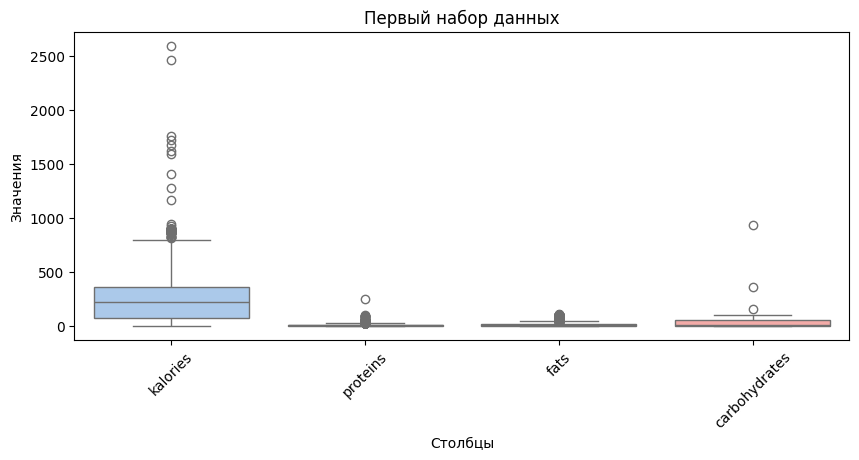

In [790]:
numeric_df_first = df[['kalories', 'proteins', 'fats', 'carbohydrates']]
numeric_df_sec = df[['size', 'price', 'old_price', 'shelf_life']]

plt.figure(figsize=(10, 4))
sns.boxplot(data=numeric_df_first)
plt.title('Первый набор данных')
plt.xlabel('Столбцы')
plt.ylabel('Значения')
plt.xticks(rotation=45)
plt.show()

Разбираемся с супер-белковыми мороженым и супер-калорийными хлебцами

In [791]:
x10_outliers = df['kalories'] > 1100
print(df[x10_outliers][['name', 'kalories']].iloc[0])
df.loc[x10_outliers, 'kalories'] = df['kalories'][x10_outliers] / 10

name        Сыр Итальянские Традиции Качотта с пеперончино...
kalories                                               1402.0
Name: 3621, dtype: object


In [792]:
vodka_outliers = df['kalories'] > 919
print(df[vodka_outliers][['name', 'kalories']])
df.loc[vodka_outliers, 'kalories'] = df['kalories'][vodka_outliers] / (df['size'][vodka_outliers]/100)

                                                   name  kalories
6910                       Водка Гусь Важный 40%, 500мл     920.0
7044  Водка Kremlin Award Органик Лимитед Эдишн 40%,...     940.0


In [793]:
icecream_outliers = df['proteins'] > 249
print(df[icecream_outliers][['name', 'proteins']])
df.loc[icecream_outliers, 'kalories'] = df['kalories'][icecream_outliers] / 10

                                                    name  proteins
11611  Мороженое сливочное Brand Ice Сливки с печенье...     250.0


In [794]:
fats_outliers = df['fats'] > 105
print(df[fats_outliers][['name', 'fats']])
df.loc[fats_outliers, 'fats'] = df['fats'][fats_outliers] / 10

                                     name   fats
5863  Гранола Ягодная Зелёная Линия, 300г  106.0


In [795]:
icecream_outliers = df['carbohydrates'] > 105
print(df[icecream_outliers][['name', 'carbohydrates']])
df.loc[icecream_outliers, 'carbohydrates'] = df['carbohydrates'][icecream_outliers] / 10

                                      name  carbohydrates
3619            Сыр Киприно Российский 50%          360.0
6405                 Водка CORN 40%, 500мл          930.0
10393  Конфеты ассорти Зелёная Линия, 200г          153.3


**Итог** 

In [796]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12082 entries, 0 to 12598
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   name                     12082 non-null  object 
 1   category                 12082 non-null  object 
 2   subcategory              12082 non-null  object 
 3   kalories                 12082 non-null  float64
 4   proteins                 12082 non-null  float64
 5   fats                     12082 non-null  float64
 6   carbohydrates            12082 non-null  float64
 7   composition              12082 non-null  object 
 8   manufacturer             12082 non-null  object 
 9   brand                    12082 non-null  object 
 10  country                  12082 non-null  object 
 11  rating                   12082 non-null  float64
 12  size                     12082 non-null  float64
 13  price                    12082 non-null  float64
 14  old_price                12

## Визуализация

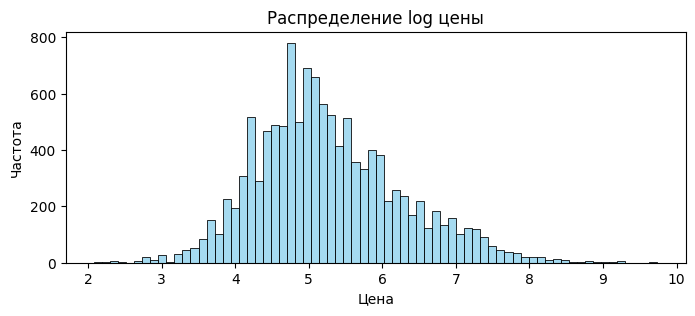

In [797]:
# Гистограмма калорий
plt.figure (figsize = (8, 3))
sns.histplot(df['price'].apply(lambda x: np.log(x+1)), color='skyblue')
plt.title('Распределение log цены')
plt.xlabel('Цена')
plt.ylabel('Частота')
plt.show()

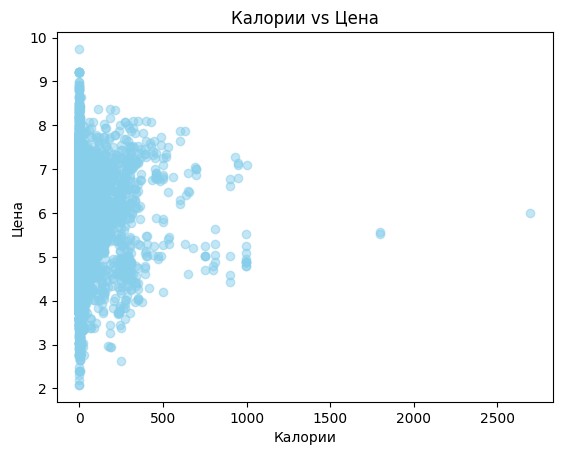

In [798]:
# Диаграмма рассеяния между калориями и белками
plt.scatter(df['fats'] * (df['size']/100) , df['price'].apply(lambda x: np.log(x+1)), color='skyblue', alpha=0.5)
plt.title('Калории vs Цена')
plt.xlabel('Калории')
plt.ylabel('Цена')
plt.show()

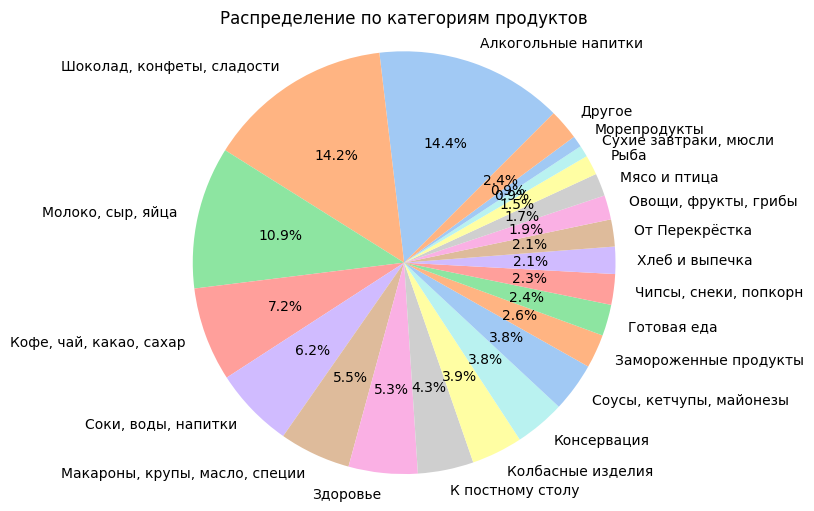

In [799]:
threshold_percentage = 0.8

category_counts = df['category'].value_counts()

small_categories_sum = category_counts[category_counts / category_counts.sum() * 100 < threshold_percentage].sum()
category_counts = category_counts[category_counts / category_counts.sum() * 100 >= threshold_percentage]
category_counts['Другое'] = small_categories_sum

plt.figure(figsize=(6, 6))
sns.set_palette("pastel")  # выбираем палитру цветов
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=45)
plt.title('Распределение по категориям продуктов')
plt.axis('equal')
plt.show()

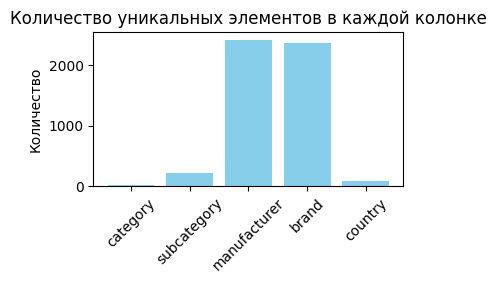

In [800]:
# Выбираем только нужные колонки
selected_columns = ['category', 'subcategory', 'manufacturer', 'brand', 'country']
selected_data = df[selected_columns]

# Получаем количество уникальных элементов в каждой колонке
unique_counts = [len(selected_data[col].unique()) for col in selected_columns]

# Строим график
plt.figure(figsize=(4, 2))
plt.bar(selected_columns, unique_counts, color='skyblue')
plt.title('Количество уникальных элементов в каждой колонке')
# plt.xlabel('Колонка')
plt.ylabel('Количество')
plt.xticks(rotation=45)
plt.show()

<Axes: >

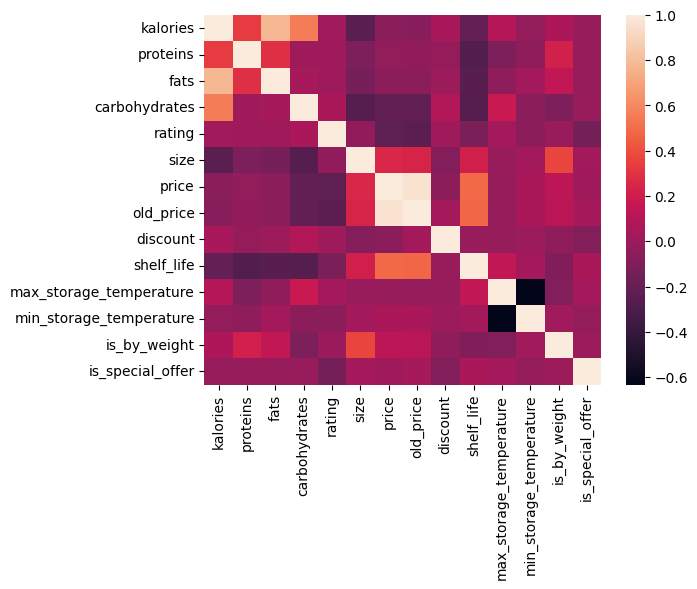

In [801]:
numeric_df = df.drop(['name', 'category', 'subcategory', 'composition', 'manufacturer', 'brand', 'country'], axis=1)
sns.heatmap(numeric_df.corr())

<Figure size 1200x800 with 0 Axes>

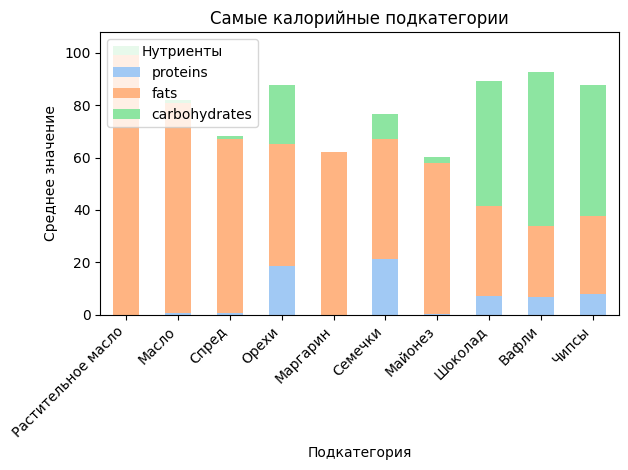

In [802]:
nutrients_by_subcategory = df.groupby('subcategory')[['kalories', 'proteins', 'fats', 'carbohydrates']] \
    .mean().sort_values(by='kalories', ascending=False)[['proteins', 'fats', 'carbohydrates']].head(10)

plt.figure(figsize=(12, 8))
nutrients_by_subcategory.plot(kind='bar', stacked=True)
plt.title('Самые калорийные подкатегории')
plt.xlabel('Подкатегория')
plt.ylabel('Среднее значение')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Нутриенты', loc='upper left')
plt.tight_layout()
plt.show()


<Figure size 1200x800 with 0 Axes>

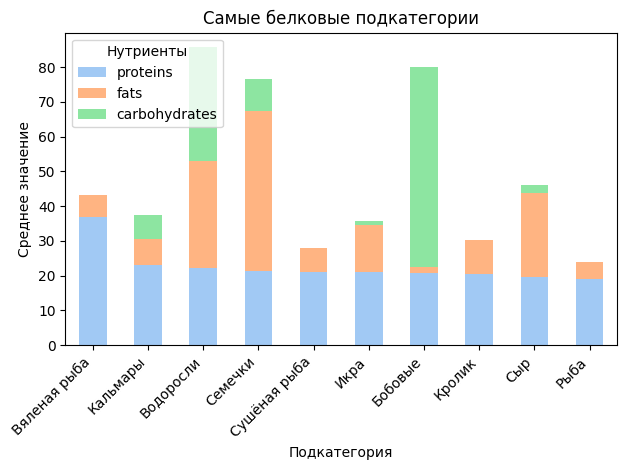

In [803]:
nutrients_by_subcategory = df.groupby('subcategory')[['proteins', 'fats', 'carbohydrates']] \
    .mean().sort_values(by='proteins', ascending=False).head(10)

plt.figure(figsize=(12, 8))
nutrients_by_subcategory.plot(kind='bar', stacked=True)
plt.title('Самые белковые подкатегории')
plt.xlabel('Подкатегория')
plt.ylabel('Среднее значение')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Нутриенты', loc='upper left')
plt.tight_layout()
plt.show()


## Создание новых признаков

`is_by_weight` - На развес ли продукт \
`is_special_offer` - Есть ли специальное предложение \
`price_per_100g` - Цена за 100 гр продукта \
`composition[0,N]` - One-hot по составу  

Признаки [is_by_weight](#is_by_weight) и [is_special_offer](#is_special_offer) уже были созданы в предобработке, создадим остальные

**Шаг 1** \
Найдем цену за 100 гр

In [804]:
df['price_per_100g'] = (df['price']/df['size']) * 100

df.sort_values(by='price_per_100g')[['name', 'price', 'size', 'price_per_100g']].head(2)

,name,price,size,price_per_100g
3309,"Соль поваренная пищевая крупная, 1кг",12.90,1000.0,1.2900
6541,Вода Малаховская №1 питьевая 1 категории негаз...,74.99,5000.0,1.4998


In [805]:
df['price_per_100g'].mean()

140.30219176198122

**Шаг 2** \
При создании `price_per_100g` будем опираться на общие требования к указанию состава продуктов 
> *Ингредиенты перечисляются по уменьшению массы в продукте* 

In [520]:
def process_string(string):

    processed_string = string.lower()

    processed_string = processed_string.replace(',',' ').replace('(',' ').replace(')',' ')

    # Оставляем только буквы русского алфавита, цифры и латинский алфавит
    processed_string = re.sub(r'[^а-яa-z0-9\s]', '', processed_string)
    return processed_string

In [521]:
composition = df[~df['composition'].isnull()]['composition'].apply(process_string)

In [522]:
composition.iloc[233]

'свинина грудинка свиная посолочная смесь соль фиксатор окраски нитрит натрия  регулятор кислотности глюконодельталактон мальтодекстрин стабилизаторы трифосфат натрия полифосфат натрия усилитель вкуса и аромата глутамат натрия антиокислитель изоаскорбат натрия экстракт дрожжей волокна пищевые бамбук  перец чрный кориандр молоко сухое красители пищевые кармин ферментированный рис декстроза стартовая культура'

In [523]:
df['composition'].iloc[233]

'свинина,грудинка свиная,посолочная смесь(соль,фиксатор окраски нитрит натрия),регулятор кислотности глюконо-дельта-лактон,мальтодекстрин,стабилизаторы трифосфат натрия,полифосфат натрия,усилитель вкуса и аромата глутамат натрия,антиокислитель изоаскорбат натрия,экстракт дрожжей,волокна пищевые(бамбук),перец чёрный,кориандр,молоко сухое,красители пищевые кармин,ферментированный рис,декстроза,стартовая культура.'

In [524]:
lines = composition[~composition.isnull()]
flat_lines = ' '.join(list(lines)).split()
tokens = sorted(set(flat_lines))
tokens = [t for t in tokens if len(t)]

In [525]:
len(tokens)

9832

Создадим свою функцию one-hot кодирования с учётом позиции ингридиентов 

In [351]:
def create_ordered_onehot_np(text, tokens):
    """ Создает one-hot вектор с учетом порядка слов, используя NumPy. """
    words = np.array(text.lower().split())
    token_indices = np.where(np.isin(tokens, words))[0]  # Индексы совпадающих токенов
    weights = 1 - (np.arange(len(words)) / len(words))   # Вектор весов
    onehot = np.zeros(len(tokens))
    np.add.at(onehot, token_indices, weights[token_indices])  # Добавляем веса по индексам
    return onehot

In [352]:
type(composition)

pandas.core.series.Series

In [353]:
composition[0]

'виноград сорта зинфандель пищевая добавка консервант антиокислитель  диоксид серы'

In [ ]:
one_hot = composition.apply(create_ordered_onehot_np, args=(tokens,))
one_hot

In [338]:
[e for e in test_h[0] if e]

[0.33333333333333337,
 1.0,
 0.2222222222222222,
 0.5555555555555556,
 0.7777777777777778,
 0.4444444444444444,
 0.6666666666666667,
 0.11111111111111116,
 0.8888888888888888]

In [ ]:
composition.iloc[0]

In [309]:
composition.iloc[:4]

0    виноград сорта зинфандель пищевая добавка конс...
1    виноград сорта арени пищевая добавка консерван...
2    сортовой состав винограда каштелао  60 аликант...
3    виноград сорта монастрель пищевая добавка конс...
Name: composition, dtype: object

In [526]:
tokens[4000:]

['инулин',
 'информация',
 'инь',
 'иодат',
 'иодид',
 'иодированная',
 'иоис',
 'ион',
 'ионный',
 'ионов',
 'ип',
 'ириса',
 'ириски',
 'ирисосливочный',
 'ирландские',
 'ирландский',
 'исключением',
 'исключено',
 'исключительно',
 'исксственные',
 'искусственного',
 'искусственные',
 'искусственный',
 'искусственных',
 'искуственные',
 'исландский',
 'исландского',
 'исландской',
 'исот',
 'испанская',
 'использ',
 'использование',
 'использованием',
 'использовании',
 'использования',
 'используемого',
 'используемой',
 'используемые',
 'используемый',
 'используемых',
 'используется',
 'используют',
 'используются',
 'использующем',
 'исправленная',
 'испраленная',
 'исспользуются',
 'источник',
 'источника',
 'источнике',
 'источники',
 'источников',
 'исходная',
 'исходном',
 'исходный',
 'италии',
 'италика',
 'италия',
 'итальянская',
 'итальянские',
 'итальянский',
 'итальянского',
 'итойори',
 'их',
 'й',
 'йогурт',
 'йогурта',
 'йогуртная',
 'йогуртной',
 'йогуртный',
 'йо

## Гипотезы

Во время работы над проектом у нас возникло несколько вопросов: 
- Влияет ли состав на оценку товара?
- Правда ли, что цена зависит от срока хранения?
- Больше ли стоят зарубежные товары?
- Скидки появляются чаще у продуктов с маленьким срока хранения?

In [806]:
correlation = df['shelf_life'].corr(df['price'])
print("Корреляция между сроком хранения и ценой:", correlation)

Корреляция между сроком хранения и ценой: 0.48699799114464504


In [807]:
from scipy import stats

is_local = df['country'] != "Россия"
not_unk = ~(df['country'] == "Unknown")

foreign_prices = df[~is_local * not_unk]['price']
local_prices = df[is_local * not_unk]['price']

t_stat, p_value = stats.ttest_ind(foreign_prices, local_prices)
print("t-статистика:", t_stat)
print("p-значение:", p_value)

if p_value < 0.05:
    print("Существенная разница в ценах между зарубежными и местными товарами")
else:
    print("Нет существенной разницы в ценах между зарубежными и местными товарами")


t-статистика: -34.256052591270944
p-значение: 2.089095951929629e-245
Существенная разница в ценах между зарубежными и местными товарами


## Машинное обучение

In [808]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

In [819]:
features = ['kalories', 'proteins', 'fats', 'carbohydrates',
            'rating', 'size', 'discount',
            'shelf_life', 'max_storage_temperature', 'min_storage_temperature',
            'is_by_weight', 'is_special_offer']

target = 'price'

X = df[features]
y = df[target]

y = np.log(1+y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [820]:
linear_regressor = LinearRegression()
linear_regressor.fit(X_train, y_train)

predictions = linear_regressor.predict(X_test)

mse = mean_squared_error(y_test, predictions)
print("Среднеквадратичная ошибка на тестовом наборе:", mse)

Среднеквадратичная ошибка на тестовом наборе: 0.541601795213248


In [821]:
gb_regressor = GradientBoostingRegressor(random_state=42)
gb_regressor.fit(X_train, y_train)

predictions = gb_regressor.predict(X_test)

mse = mean_squared_error(y_test, predictions)
print("Среднеквадратичная ошибка на тестовом наборе:", mse)

Среднеквадратичная ошибка на тестовом наборе: 0.3302583073926989


In [822]:
X_test.head(10)

,kalories,proteins,fats,carbohydrates,rating,size,discount,shelf_life,max_storage_temperature,min_storage_temperature,is_by_weight,is_special_offer
5363,150.0,15.0,10.0,0.0,4.93,490.0,0.0,8.0,0.0,0.0,0,False
7494,45.0,0.0,0.0,11.5,4.92,1000.0,17.0,365.0,25.0,0.0,0,False
1858,4.0,0.0,0.0,0.0,4.88,36.0,0.0,730.0,0.0,0.0,0,False
1563,0.0,0.0,0.0,0.0,4.95,190.0,0.0,730.0,30.0,6.0,0,False
2202,94.7,0.0,0.0,0.0,4.89,750.0,13.0,9999.0,20.0,5.0,0,False
1015,72.0,0.0,0.0,0.0,4.67,750.0,15.0,9999.0,50.0,-40.0,0,False
487,230.0,21.0,16.0,0.0,4.84,270.0,0.0,30.0,6.0,0.0,0,False
11934,85.0,1.5,5.4,7.5,4.28,300.0,30.0,365.0,50.0,-40.0,0,False
9265,420.0,8.5,14.0,59.0,4.84,20.0,38.0,270.0,20.0,-40.0,0,False
2727,370.0,13.0,3.5,72.0,4.92,400.0,0.0,365.0,50.0,-40.0,0,False


In [823]:
np.exp(predictions[:10])

array([418.13819896, 117.38760021, 176.54322537, 211.7739814 ,
       840.99949541, 838.48139809, 266.69043771, 117.91985621,
        47.81907451, 122.04111478])

In [824]:
np.exp(y_test[:10])

5363      210.99
7494      120.99
1858      150.99
1563      550.99
2202      380.99
1015     1100.00
487       300.99
11934     160.99
9265       43.99
2727      160.99
Name: price, dtype: float64